# Evaluate SnowModel output at SNOTEL

Created by Nina Aragon, Feb 2020. 

In [1]:
# Import all of the python packages used in this workflow.
import scipy
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
import os, sys
from pylab import *
import pandas as pd
import numpy as np
import osgeo
from osgeo import gdal
from shapely import geometry as sgeom
import osr
import xarray
import ulmo
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import geopandas as gpd
from Depth2SWE import

##USER INPUTS##
#start date
st = "2014-10-01"
#end date
ed = "2019-09-29"

#number of timesteps in model run 
num_mod_timesteps = 365 * 5

#model filename
inFile = 'swed.gdat'
#from .ctl file
nx = 1382
ny = 2476
#ncols = 2476 
#nrows = 1382
xll = 487200
#xll = 4690100
yll = 4690100
#yll = 487200
clsz = 100

#Snotel bounding box
Bbox = {
    'latmax' : 44.582480,
    'latmin' : 42.363116,
    'lonmax': -109.477849,
    'lonmin': -111.155208,}
#ltmn = 42.363116
#ltmx = 44.582480
#lnmn = -111.155208
#lnmx = -109.477849

# Snotel projection
stn_proj = 'epsg:4326' #WGS84
#model projection
mod_proj = 'epsg:32612' #UTM zone 12N

print(type(Bbox))
print(Bbox['latmax'])

<class 'dict'>
44.58248


# Use ulmo to get SNOTEL station metadata within bounding box
## Get SNOTEL metadata over modeling domain

In [2]:
#function to extract data
def sites_asgdf(ulmo_getsites, crs=stn_proj):
    """ Convert ulmo.cuahsi.wof.get_sites response into a point GeoDataframe
    """
    
    # Note: Found one SNOTEL site that was missing the location key
    sites_df = pd.DataFrame.from_records([
        OrderedDict(code=s['code'], 
        longitude=float(s['location']['longitude']), 
        latitude=float(s['location']['latitude']), 
        name=s['name'], 
        elevation_m=s['elevation_m'])
        for _,s in ulmo_getsites.items()
        if 'location' in s
    ])

    sites_gdf = gpd.GeoDataFrame(
        sites_df, 
        geometry=gpd.points_from_xy(sites_df['longitude'], sites_df['latitude']),
        crs=crs
    )
    return sites_gdf

In [3]:
# Convert the bounding box dictionary to a shapely Polygon geometry using sgeom.box
box_sgeom = sgeom.box(Bbox['lonmin'], Bbox['latmin'], Bbox['lonmax'], Bbox['latmax'])
box_gdf = gpd.GeoDataFrame(geometry=[box_sgeom], crs=stn_proj)

# WaterML/WOF WSDL endpoint url 
wsdlurl = "http://hydroportal.cuahsi.org/Snotel/cuahsi_1_1.asmx?WSDL"

# get dictionary of snotel sites 
sites = ulmo.cuahsi.wof.get_sites(wsdlurl)

#turn sites as geodataframe 
snotel_gdf = sites_asgdf(sites)

In [4]:
CSO_gdf = gpd.sjoin(snotel_gdf, box_gdf, how="inner")
CSO_gdf.drop(columns='index_right', inplace=True)
#reset inex
CSO_gdf.index = range(len(CSO_gdf.index))
#CSO_gdf.index = CSO_gdf['code']

#add columns with projected coordinates 
CSO_proj = CSO_gdf.to_crs({'init' :mod_proj})
CSO_gdf['lon_proj'] = CSO_proj.geometry.x
CSO_gdf['lat_proj'] = CSO_proj.geometry.y
CSO_gdf.head()

/Users/aragon/anaconda3/envs/hydrology/lib/python3.8/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


,code,longitude,latitude,name,elevation_m,geometry,lon_proj,lat_proj
0,314_WY_SNTL,-110.445442,43.940189,Base Camp,2151.887939453125,POINT (-110.44544 43.94019),544505.845453,4.865379e+06
1,347_MT_SNTL,-111.128029,44.508320,Black Bear,2490.216064453125,POINT (-111.12803 44.50832),489823.440274,4.928341e+06
2,350_WY_SNTL,-109.793327,44.376671,Blackwater,2980.944091796875,POINT (-109.79333 44.37667),596129.923439,4.914418e+06
3,353_WY_SNTL,-110.609734,42.964001,Blind Bull Sum,2636.52001953125,POINT (-110.60973 42.96400),531828.554679,4.756891e+06
4,379_WY_SNTL,-109.670212,43.697330,Burroughs Creek,2667,POINT (-109.67021 43.69733),607155.527746,4.839116e+06


## Get SNOTEL SWE data in domain over time period of interest

In [5]:
#get snotel station data

def fetch(sitecode, variablecode, start_date, end_date):
    print(sitecode, variablecode, start_date, end_date)
    values_df = None
    try:
        #Request data from the server
        site_values = ulmo.cuahsi.wof.get_values(wsdlurl, 'SNOTEL:'+sitecode, variablecode, start=start_date, end=end_date)
        #Convert to a Pandas DataFrame   
        values_df = pd.DataFrame.from_dict(site_values['values'])
        #Parse the datetime values to Pandas Timestamp objects
        values_df['datetime'] = pd.to_datetime(values_df['datetime'])
        #Set the DataFrame index to the Timestamps
        values_df = values_df.set_index('datetime')
        #Convert values to float and replace -9999 nodata values with NaN
        values_df['value'] = pd.to_numeric(values_df['value']).replace(-9999, np.nan)
        #Remove any records flagged with lower quality
        values_df = values_df[values_df['quality_control_level_code'] == '1']
    except:
        print("Unable to fetch %s" % variablecode)
    return values_df

stn_swe = pd.DataFrame(index=pd.date_range(start=st, end=ed))

for i in range(CSO_gdf.shape[0]):
    try:
        sitecode = CSO_gdf.code[i]
        swe = fetch(sitecode, variablecode='SNOTEL:WTEQ_D', start_date=st, end_date=ed)
        stn_swe[sitecode] = swe.value
    except:
        print(sitecode, 'has no data')
        stn_swe[sitecode] = np.nan
        
    
stn_swe.head()

314_WY_SNTL SNOTEL:WTEQ_D 2014-10-01 2019-09-29
347_MT_SNTL SNOTEL:WTEQ_D 2014-10-01 2019-09-29
350_WY_SNTL SNOTEL:WTEQ_D 2014-10-01 2019-09-29
353_WY_SNTL SNOTEL:WTEQ_D 2014-10-01 2019-09-29
379_WY_SNTL SNOTEL:WTEQ_D 2014-10-01 2019-09-29
419_WY_SNTL SNOTEL:WTEQ_D 2014-10-01 2019-09-29
421_WY_SNTL SNOTEL:WTEQ_D 2014-10-01 2019-09-29


<?xml version="1.0" encoding="UTF-8"?>
<SOAP-ENV:Envelope xmlns:SOAP-ENV="http://schemas.xmlsoap.org/soap/envelope/" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xmlns:ns0="http://schemas.xmlsoap.org/soap/envelope/" xmlns:ns1="http://www.cuahsi.org/his/1.1/ws/">
   <SOAP-ENV:Header/>
   <ns0:Body>
      <ns1:GetValues>
         <ns1:location>SNOTEL:421_WY_SNTL</ns1:location>
         <ns1:variable>SNOTEL:WTEQ_D</ns1:variable>
         <ns1:startDate>2014-10-01T00:00:00</ns1:startDate>
         <ns1:endDate>2019-09-29T00:00:00</ns1:endDate>
      </ns1:GetValues>
   </ns0:Body>
</SOAP-ENV:Envelope>


Unable to fetch SNOTEL:WTEQ_D
421_WY_SNTL has no data
460_WY_SNTL SNOTEL:WTEQ_D 2014-10-01 2019-09-29
468_WY_SNTL SNOTEL:WTEQ_D 2014-10-01 2019-09-29
1082_WY_SNTL SNOTEL:WTEQ_D 2014-10-01 2019-09-29
497_WY_SNTL SNOTEL:WTEQ_D 2014-10-01 2019-09-29
499_WY_SNTL SNOTEL:WTEQ_D 2014-10-01 2019-09-29
506_WY_SNTL SNOTEL:WTEQ_D 2014-10-01 2019-09-29
944_WY_SNTL SNOTEL:WTEQ_D 2014-10-01 2019-09-29
555_WY_SNTL SNOTEL:WTEQ_D 2014-10-01 2019-09-29
577_WY_SNTL SNOTEL:WTEQ_D 2014-10-01 2019-09-29
585_WY_SNTL SNOTEL:WTEQ_D 2014-10-01 2019-09-29
597_WY_SNTL SNOTEL:WTEQ_D 2014-10-01 2019-09-29
661_WY_SNTL SNOTEL:WTEQ_D 2014-10-01 2019-09-29
689_WY_SNTL SNOTEL:WTEQ_D 2014-10-01 2019-09-29
730_WY_SNTL SNOTEL:WTEQ_D 2014-10-01 2019-09-29
764_WY_SNTL SNOTEL:WTEQ_D 2014-10-01 2019-09-29
765_WY_SNTL SNOTEL:WTEQ_D 2014-10-01 2019-09-29
779_WY_SNTL SNOTEL:WTEQ_D 2014-10-01 2019-09-29
806_WY_SNTL SNOTEL:WTEQ_D 2014-10-01 2019-09-29
807_WY_SNTL SNOTEL:WTEQ_D 2014-10-01 2019-09-29
816_WY_SNTL SNOTEL:WTEQ_D 2014-10

,314_WY_SNTL,347_MT_SNTL,350_WY_SNTL,353_WY_SNTL,379_WY_SNTL,419_WY_SNTL,421_WY_SNTL,460_WY_SNTL,468_WY_SNTL,1082_WY_SNTL,...,765_WY_SNTL,779_WY_SNTL,806_WY_SNTL,807_WY_SNTL,816_WY_SNTL,822_WY_SNTL,831_WY_SNTL,837_WY_SNTL,868_WY_SNTL,878_WY_SNTL
2014-10-01,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.9,...,0.0,0.0,0.3,0.0,0.0,0.0,0.0,0.6,0.0,NaN
2014-10-02,0.0,0.0,0.2,0.0,0.0,0.0,NaN,0.0,0.0,1.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.7,0.0,NaN
2014-10-03,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,1.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6,0.0,NaN
2014-10-04,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2014-10-05,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [6]:
#convert SNOTEL units[in] to SnowModel units [m]
for z in range(CSO_gdf.shape[0]):
    sitecode = CSO_gdf.code[z]
    stn_swe['m'+sitecode] = stn_swe[sitecode].mul(0.0254)

stn_swe.head()

,314_WY_SNTL,347_MT_SNTL,350_WY_SNTL,353_WY_SNTL,379_WY_SNTL,419_WY_SNTL,421_WY_SNTL,460_WY_SNTL,468_WY_SNTL,1082_WY_SNTL,...,m765_WY_SNTL,m779_WY_SNTL,m806_WY_SNTL,m807_WY_SNTL,m816_WY_SNTL,m822_WY_SNTL,m831_WY_SNTL,m837_WY_SNTL,m868_WY_SNTL,m878_WY_SNTL
2014-10-01,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.9,...,0.0,0.0,0.00762,0.0,0.0,0.0,0.0,0.01524,0.0,NaN
2014-10-02,0.0,0.0,0.2,0.0,0.0,0.0,NaN,0.0,0.0,1.2,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.01778,0.0,NaN
2014-10-03,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,1.1,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.01524,0.0,NaN
2014-10-04,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,NaN
2014-10-05,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,NaN


# Extract SWE data from SnowModel output 

In [7]:
#Build lat/lon array 
#Longitudes
ln = np.arange(xll, xll+nx*clsz, clsz)
print(ln.shape)
#Latitudes
lt = np.arange(yll, yll+ny*clsz, clsz)

#open the grads model output file, 'rb' indicates reading from binary file
grads_data = open(inFile,'rb')
# convert to a numpy array 
numpy_data = np.fromfile(grads_data,dtype='float32',count=-1)
#close grads file 
grads_data.close()
#reshape the data 
numpy_data = np.reshape(numpy_data,(num_mod_timesteps,ny,nx))
print(np.shape(numpy_data))


(1382,)
(1825, 2476, 1382)


<class 'xarray.core.dataarray.DataArray'>


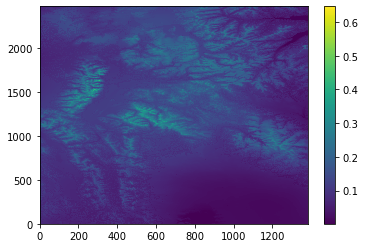

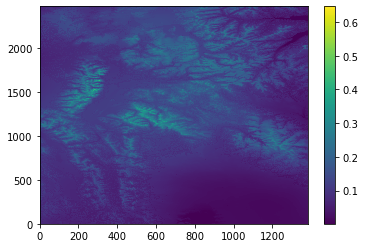

In [8]:
#plot to check results
figure(1)
plt.pcolormesh(numpy_data[60,:,:])
colorbar()

#convert to xarray 
swe = xarray.DataArray(numpy_data,dims=('time','lat','lon'), 
                        coords={'time':pd.date_range(st, periods=num_mod_timesteps),
                                'lat':lt,'lon':ln})
#plot to check results 
figure(2)
print(type(swe))
plt.pcolormesh(swe[60,:,:])
colorbar()

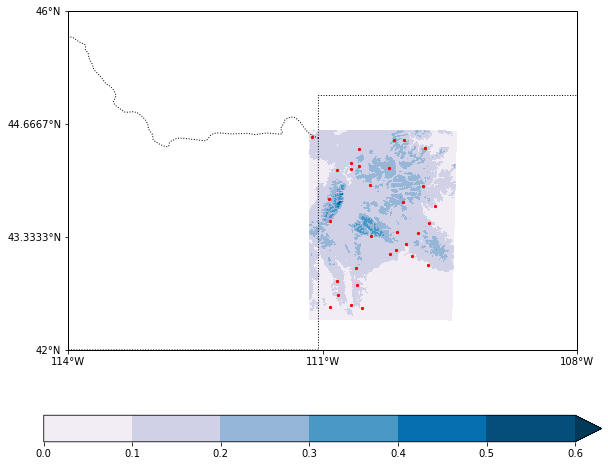

In [9]:
# plot georeferenced SnowModel output with SNOTEL stations 
plt.figure(figsize=(10,8))

from_proj = ccrs.epsg(32612)
to_proj = ccrs.PlateCarree()

#levs = np.arange(0, 0.6, 0.05)

states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

# Using cartopy, create the map projection and plot the data
ax = plt.axes(projection=to_proj)
ax.add_feature(states_provinces, edgecolor='black',linestyle=':')
ax.coastlines()

# Can change color scheme using the cmap argument
#plt.contourf(ln, lt, swe, levs, transform=from_proj, extend='max', cmap="PuBu")
plt.contourf(ln, lt, swe[60,:,:], transform=from_proj, extend='max', cmap="PuBu")

plt.colorbar(orientation="horizontal", fraction=0.07)
CSO_gdf.plot(ax=ax, markersize=5, color='r')

plt.xlim(-113, -108)
plt.ylim(42, 46)

ax.set_xticks(np.linspace(-114, -108, 3), crs=to_proj)
ax.set_yticks(np.linspace(42, 46, 4), crs=to_proj)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

# To zoom in on data:
#plt.xlim(-125, -120)
#plt.ylim(38, 44)
plt.show()

# Get the model swe values for each SNOTEL

In [10]:
#get index for each SNOTEL station relative to the SnowModel output

lon_idx = np.empty(CSO_gdf.shape[0])
lat_idx = np.empty(CSO_gdf.shape[0])
for z in range(CSO_gdf.shape[0]):
    lons = abs(CSO_gdf.lon_proj[z]-ln)
    loIDX = [i for i, value in enumerate(lons) if value == np.min(abs(CSO_gdf.lon_proj[z]-ln))] 
    lon_idx[z] = loIDX[0]
    lats = abs(CSO_gdf.lat_proj[z]-lt)
    laIDX = [i for i, value in enumerate(lats) if value == np.min(abs(CSO_gdf.lat_proj[z]-lt))]
    lat_idx[z] = laIDX[0]

CSO_gdf['lat_idx'] = lat_idx
CSO_gdf['lon_idx'] = lon_idx

In [11]:
mod_swe = pd.DataFrame(index=pd.date_range(start=st, end=ed))

for i in range(CSO_gdf.shape[0]):
    sitecode = CSO_gdf.code[i]
    mod_swe[sitecode] = np.squeeze(swe[:,int(CSO_gdf.lat_idx[i]),int(CSO_gdf.lon_idx[i])].values)
mod_swe.head()

,314_WY_SNTL,347_MT_SNTL,350_WY_SNTL,353_WY_SNTL,379_WY_SNTL,419_WY_SNTL,421_WY_SNTL,460_WY_SNTL,468_WY_SNTL,1082_WY_SNTL,...,765_WY_SNTL,779_WY_SNTL,806_WY_SNTL,807_WY_SNTL,816_WY_SNTL,822_WY_SNTL,831_WY_SNTL,837_WY_SNTL,868_WY_SNTL,878_WY_SNTL
2014-10-01,0.0,0.0,0.003908,0.000751,0.001317,0.0,0.0,0.0,0.000185,0.001274,...,5.152194e-04,0.000409,0.000017,0.0,0.0,0.001448,0.000865,0.002528,0.0,0.0
2014-10-02,0.0,0.0,0.005157,0.000000,0.000165,0.0,0.0,0.0,0.000000,0.000002,...,1.280569e-10,0.000000,0.000272,0.0,0.0,0.001531,0.000000,0.003072,0.0,0.0
2014-10-03,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
2014-10-04,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
2014-10-05,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0


Text(0.5, 1.0, '314_WY_SNTL')

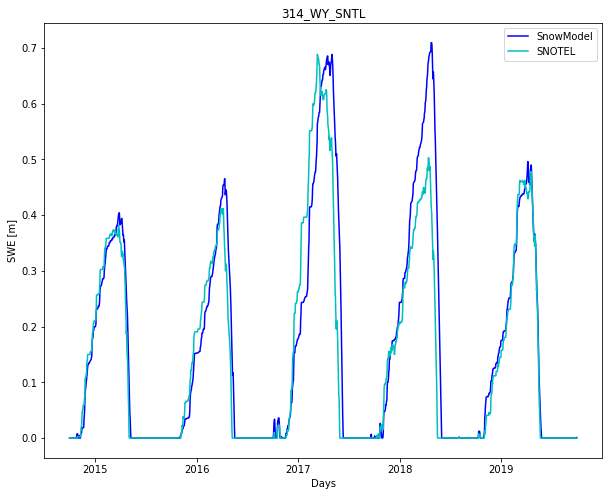

In [12]:
sitecode = CSO_gdf.code[0]
fig = plt.figure(1,figsize=(10,8))
plt.plot(mod_swe[sitecode],'b-', label = 'SnowModel')
plt.plot(stn_swe['m'+sitecode],'c-',label = 'SNOTEL')
plt.legend()
plt.xlabel( "Days")
plt.ylabel( "SWE [m]")
plt.title(sitecode)
#fig.savefig("swe_stn_mod1.pdf", bbox_inches='tight')

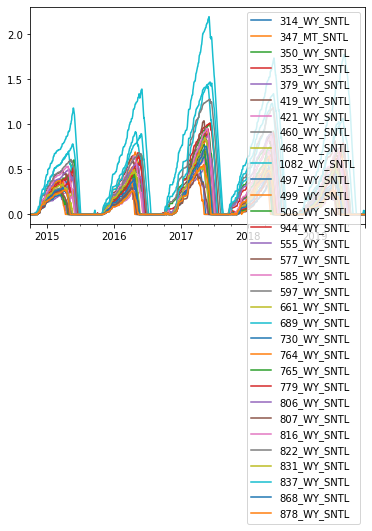

In [13]:
mod_swe.plot()

# Calculate stats

In [14]:
swe_stats = pd.DataFrame(index=CSO_gdf.code, columns=['MAE','MBE','RMSE', 'NSE', 'KGE'])

for z in range(CSO_gdf.shape[0]):
    try:
        sitecode = CSO_gdf.code[z]
        #mean absolute error
        MAE = (sum(abs(mod_swe[sitecode] - stn_swe['m'+sitecode])))/mod_swe.shape[0]

        #mean bias error
        MBE = (sum(mod_swe[sitecode] - stn_swe['m'+sitecode]))/mod_swe.shape[0]

        #root mean squared error
        RMSE = np.sqrt((sum((mod_swe[sitecode] - stn_swe['m'+sitecode])**2))/mod_swe.shape[0])

        # Nash-Sutcliffe model efficiency coefficient, 1 = perfect, assumes normal data 
        nse_top = sum((mod_swe[sitecode] - stn_swe['m'+sitecode])**2)
        nse_bot = sum((stn_swe['m'+sitecode] - mean(stn_swe['m'+sitecode]))**2)
        NSE = (1-(nse_top/nse_bot))

        # Kling-Gupta Efficiency, 1 = perfect
        kge_std = (np.std(mod_swe[sitecode])/np.std(stn_swe['m'+sitecode]))
        kge_mean = (mean(mod_swe[sitecode])/mean(stn_swe['m'+sitecode]))
        kge_r = corrcoef((stn_swe['m'+sitecode])
                          ,(mod_swe[sitecode]))[1,0]
        KGE = (1 - (sqrt((kge_r-1)**2)+((kge_std-1)**2)+(kge_mean-1)**2))
        
        swe_stats.loc[sitecode] = pd.Series({'MAE':MAE,'MBE':MBE,'RMSE':RMSE, 'NSE':NSE, 'KGE':KGE})
    except:
        print('invalid value')

#print(swe_stats)

#add columns to stn metadata gdf
CSO_gdf['MAE']=swe_stats.MAE.values
CSO_gdf['MBE']=swe_stats.MBE.values
CSO_gdf['RMSE']=swe_stats.RMSE.values
CSO_gdf['NSE']=swe_stats.NSE.values
CSO_gdf['KGE']=swe_stats.KGE.values

<ipython-input-14-1570f041a8e0>:18: RuntimeWarning: invalid value encountered in double_scalars
  NSE = (1-(nse_top/nse_bot))


In [15]:
#get elevation data 
pathToRaster = r'DEM_WY.tif'
ds = gdal.Open(pathToRaster,  gdal.GA_ReadOnly)
#ds = gdal.Open('DEM_WY.tif')
data = ds.GetRasterBand(1).ReadAsArray()
data = data[::-1]  
width = ds.RasterXSize
height = ds.RasterYSize
gt = ds.GetGeoTransform()
minx = gt[0]
miny = gt[3] + width*gt[4] + height*gt[5] 
maxx = gt[0] + width*gt[1] + height*gt[2]
maxy = gt[3] 

#Build lat/lon array
#Longitudes
lns = np.arange(minx, maxx, gt[1])
#print(ln.shape)
#Latitudes
lts = np.arange(miny, maxy, gt[1])

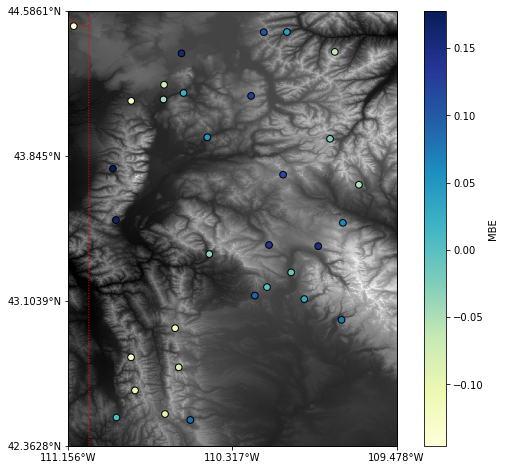

In [17]:
# plot elevation data with stats 
stat_var = CSO_gdf.MBE
stat_name = 'MBE'

# # create the colorbar
norm = colors.Normalize(vmin=stat_var.min(),vmax=stat_var.max())
cbar = plt.cm.ScalarMappable(norm=norm, cmap='YlGnBu')

#figure
fig = plt.figure(figsize=(10,8))

from_proj =ccrs.PlateCarree()
to_proj = ccrs.PlateCarree()

# Using cartopy, create the map projection and plot the data
ax = plt.axes(projection=to_proj)
ax.add_feature(states_provinces, edgecolor='r',linestyle=':')

# Can change color scheme using the cmap argument
plt.pcolormesh(lns, lts,data,cmap ='gray', transform=from_proj)

#Add stats data 
CSO_gdf.plot(column=stat_name, cmap='YlGnBu', legend=False, ax=ax,markersize=45,edgecolors='k')

# add colorbar
#plt.colorbar(orientation="horizontal", fraction=0.07)
ax_cbar = plt.colorbar(cbar, ax=ax)
# add label for the colorbar
ax_cbar.set_label(stat_name)

#add lat, lon to fig
ax.set_xticks(np.linspace(minx, maxx, 3), crs=to_proj)
ax.set_yticks(np.linspace(miny, maxy, 4), crs=to_proj)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

# To zoom in on data:
plt.xlim(minx, maxx)
plt.ylim(miny, maxy)
plt.show()
#fig.savefig(stat_name+'.png', dpi = 300, bbox_inches='tight')